In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Random Walk

In [4]:
np.random.seed(42)

In [5]:
def random_walk_2d(N):
    x = np.zeros(N+1)
    y = np.zeros(N+1)
    for i in range(1, N+1):
        dx = 2 * np.random.random() - 1
        dy = 2 * np.random.random() - 1
        L = np.sqrt(dx**2 + dy**2)
        dx /= L
        dy /= L
        x[i] = x[i-1] + dx
        y[i] = y[i-1] + dy
    return x, y

In [6]:
def simulate_trials_2d(M, N):
    r_squared = np.zeros(N)
    for trial in range(M):
        x, y = random_walk_2d(N)
        r2 = x[1:]**2 + y[1:]**2
        r_squared += r2
    return r_squared / M

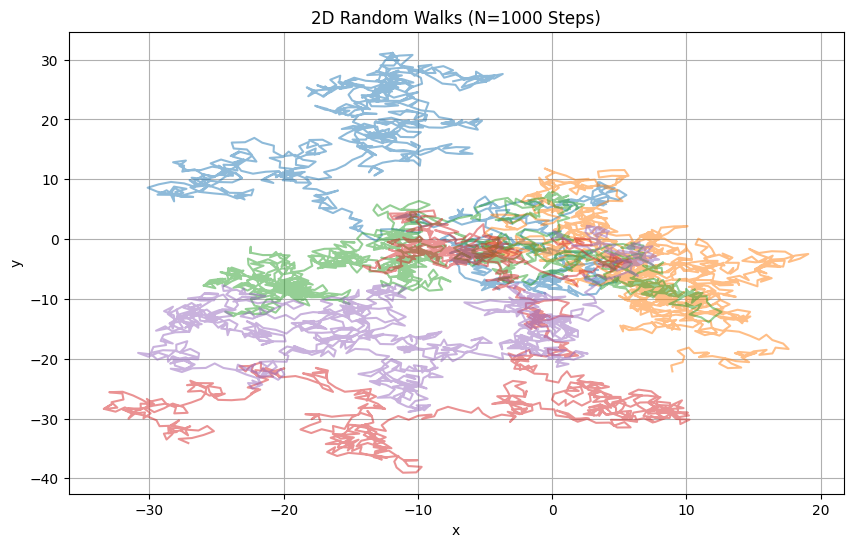

In [7]:
plt.figure(figsize=(10, 6))
for _ in range(5):
    x, y = random_walk_2d(1000)
    plt.plot(x, y, alpha=0.5)
plt.title("2D Random Walks (N=1000 Steps)")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

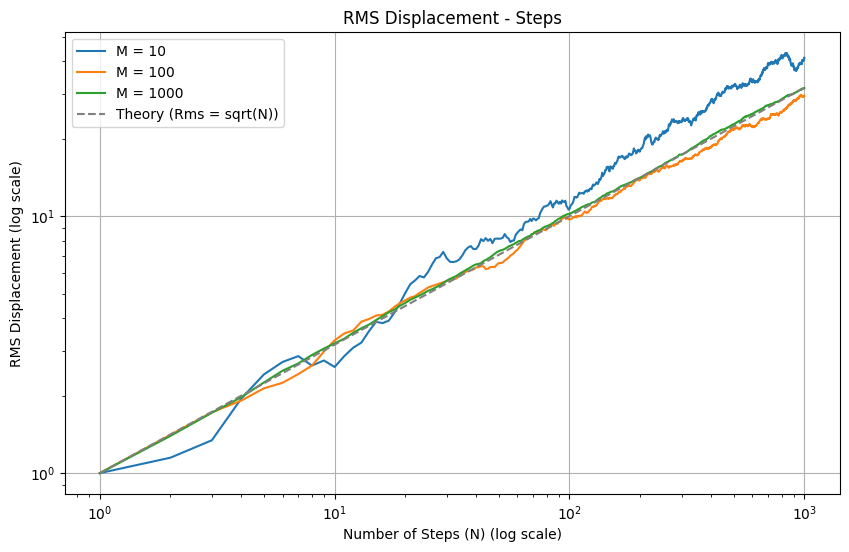

In [8]:
N = 1000
Ms = [10, 100, 1000]
steps = np.arange(1, N+1)

plt.figure(figsize=(10, 6))

for M in Ms:
    r_squared_avg_2d = simulate_trials_2d(M, N)
    R_rms = np.sqrt(r_squared_avg_2d)
    
    plt.plot(steps, R_rms, label=f"M = {M}")

plt.plot(steps, np.sqrt(steps), '--', label="Theory (Rms = sqrt(N))", color='gray')

plt.yscale('log')
plt.xscale('log')
plt.title("RMS Displacement - Steps")
plt.xlabel("Number of Steps (N) (log scale)")
plt.ylabel("RMS Displacement (log scale)")
plt.legend()
plt.grid()
plt.show()

(Επιπλέον) Implement a 3D Random Walk

In [10]:
def random_walk_3d(N):
    x = np.zeros(N+1)
    y = np.zeros(N+1)
    z = np.zeros(N+1)
    for i in range(1, N+1):
        dx = 2 * np.random.random() - 1
        dy = 2 * np.random.random() - 1
        dz = 2 * np.random.random() - 1
        L = np.sqrt(dx**2 + dy**2 + dz**2)
        dx /= L
        dy /= L
        dz /= L
        x[i] = x[i-1] + dx
        y[i] = y[i-1] + dy
        z[i] = z[i-1] + dz
    return x, y, z

In [11]:
def simulate_trials_3d(M, N):
    r_squared = np.zeros(N)
    for trial in range(M):
        x, y, z = random_walk_2d(N)
        r2 = x[1:]**2 + y[1:]**2 + z[1:]**2
        r_squared += r2
    return r_squared / M

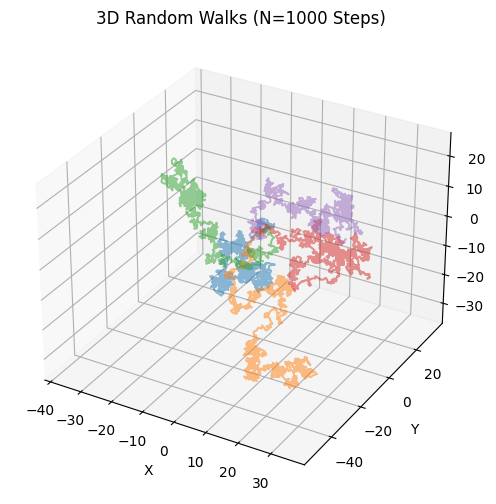

In [12]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

for _ in range(5):
    x, y, z = random_walk_3d(1000)
    ax.plot(x, y, z, alpha=0.5)

ax.set_title("3D Random Walks (N=1000 Steps)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.show()

---

## 2D Ising model

In [14]:
def per(i, N):
    if i < 0:
        return i + N
    elif i >= N:
        return i - N
    return i

In [15]:
def setup_lattice(N):
    aux1 = np.zeros((N**2, 2), dtype=int)
    aux2 = np.zeros((N, N), dtype=int)
    nn = np.zeros((N**2, 4), dtype=int)

    counter = 0
    for ix in range(N):
        for iy in range(N):
            aux1[counter, 0] = ix
            aux1[counter, 1] = iy
            aux2[ix, iy] = counter
            counter += 1

    for i in range(N**2):
        ix = aux1[i, 0]
        iy = aux1[i, 1]

        nn[i, 0] = aux2[per(ix + 1, N), per(iy, N)]  # Right
        nn[i, 1] = aux2[per(ix - 1, N), per(iy, N)]  # Left
        nn[i, 2] = aux2[per(ix, N), per(iy + 1, N)]  # Bottom
        nn[i, 3] = aux2[per(ix, N), per(iy - 1, N)]  # Top

    return aux1, aux2, nn

In [16]:
# Cold-start (all spins up) or hot-start (random spins)
def initialize_spins(N, mode='cold'):
    if mode == 'cold':
        return np.ones(N**2, dtype=int)
    elif mode == 'hot':
        return np.where(np.random.rand(N**2) > 0.5, 1, -1)

In [17]:
def Hamiltonian(S, nn, J, B):
    E = 0
    for i in range(len(S)):
        for j in range(4):
            E -= J * S[i] * S[nn[i, j]]
        E -= B * S[i]
    return E / 2  # Correct for double-counting

In [18]:
def DeltaH(S, nn, J, B, r):
    return 2 * S[r] * (J * np.sum(S[nn[r]]) + B)

In [19]:
def monte_carlo(S, nn, J, B, T, N_sweeps, N_skip, thermalization_sweeps=500): #500
    N_sites = len(S)
    Etot = Hamiltonian(S, nn, J, B)
    E_vals = []
    M_vals = []

    # Thermalization phase
    for _ in range(thermalization_sweeps * N_sites):
        k = np.random.randint(N_sites)
        dE = DeltaH(S, nn, J, B, k)
        if dE < 0 or np.random.rand() < np.exp(-dE / T):
            S[k] *= -1
            Etot += dE

    # Measurement phase
    for sweep in range(N_sweeps):
        for _ in range(N_sites):
            k = np.random.randint(N_sites)
            dE = DeltaH(S, nn, J, B, k)
            if dE < 0 or np.random.rand() < np.exp(-dE / T):
                S[k] *= -1
                Etot += dE

        if sweep % N_skip == 0:
            E_vals.append(Etot)
            M_vals.append(np.sum(S))

    return np.array(E_vals), np.array(M_vals)

In [20]:
def observables(E_vals, M_vals, N, T, B):
    N_atoms = N**2
    E_avg = np.mean(E_vals) / N_atoms  # Average energy per atom
    if B == 0:
        M_avg = np.mean(np.abs(M_vals)) / N_atoms  # Average magnetization per atom (absolute value)
    else:
        M_avg = np.mean(M_vals) / N_atoms  # Average magnetization per atom
    C = (np.var(E_vals) / (T**2)) / N_atoms  # Heat capacity
    chi = (np.var(M_vals) / T) / N_atoms  # Susceptibility
    return E_avg, M_avg, C, chi

In [21]:
def plot_spin_map(S, aux1, N, title=''):
    lattice = np.zeros((N, N), dtype=int)
    for b in range(len(S)):
        i, j = aux1[b]  # Get (i, j) coordinates of the site
        lattice[i, j] = S[b]  # Assign spin value to the lattice site
    plt.imshow(lattice, cmap='binary')
    plt.title(title)
    plt.colorbar(label='Spin')
    plt.show()

In [22]:
def plot_spin(inv_Tc, B=0, N=20, J=1):
    aux1, _, nn = setup_lattice(N)

    Tc = 1 / inv_Tc
    temps = [Tc - 0.5, Tc, Tc + 0.5]

    for T in temps:
        S = initialize_spins(N, 'cold')
        monte_carlo(S, nn, J, B, T, N_sweeps=2000, N_skip=20) # 1000, 10
        plot_spin_map(S, aux1, N, title=f"J={J}, B={B}, T={T:.2f}")

In [23]:
def run_simulation(N=20, J=1, B=0, T_vals = np.linspace(1.2, 5, 100), mode='hot', N_sweeps=2000, N_skip=20): #1000, 10 T_vals=np.linspace(1.2, 3.5, 100)
    aux1, aux2, nn = setup_lattice(N)
    results = {'T': [], 'E': [], 'M': [], 'C': [], 'chi': []}
    for T in T_vals:
        S = initialize_spins(N, mode)
        E_vals, M_vals = monte_carlo(S, nn, J, B, T, N_sweeps, N_skip)
        E, M, C, chi = observables(E_vals, M_vals, N, T, B)
        results['T'].append(T)
        results['E'].append(E)
        results['M'].append(M)
        results['C'].append(C)
        results['chi'].append(chi)
    return results, aux1

In [24]:
def plot_results(results, J=1, B=0):
    T = results['T']
    inv_T = 1 / np.array(T)
    plt.figure(figsize=(12, 8))
    exact_inv_Tc = 0.4406868 if J == 1 and B == 0 else None

    plt.subplot(2, 2, 1)
    plt.plot(inv_T, results['E'], label='Energy')
    if exact_inv_Tc:
        plt.axvline(exact_inv_Tc, color='gray', linestyle='--', label=f'Exact 1/Tc={exact_inv_Tc:.3f}')
    plt.ylabel('E per atom')
    plt.xlabel('1 / (kb T)')
    plt.legend()
    plt.grid()

    plt.subplot(2, 2, 2)
    plt.plot(inv_T, results['M'], label='Magnetization', color='orange')
    if exact_inv_Tc:
        plt.axvline(exact_inv_Tc, color='gray', linestyle='--')
    plt.ylabel('|M| per atom' if B == 0 else 'M per atom')
    plt.xlabel('1 / (kb T)')
    plt.grid()

    plt.subplot(2, 2, 3)
    plt.plot(inv_T, results['C'], label='Heat Capacity', color='green')
    if exact_inv_Tc:
        plt.axvline(exact_inv_Tc, color='gray', linestyle='--')
    plt.ylabel('C')
    plt.xlabel('1 / (kb T)')
    plt.grid()

    plt.subplot(2, 2, 4)
    plt.plot(inv_T, results['chi'], label='Susceptibility', color='red')
    if exact_inv_Tc:
        plt.axvline(exact_inv_Tc, color='gray', linestyle='--')
    plt.ylabel('chi')
    plt.xlabel('1 / (kb T)')
    plt.grid()

    plt.suptitle(f'J={J}, B={B}')
    plt.tight_layout()
    plt.show()

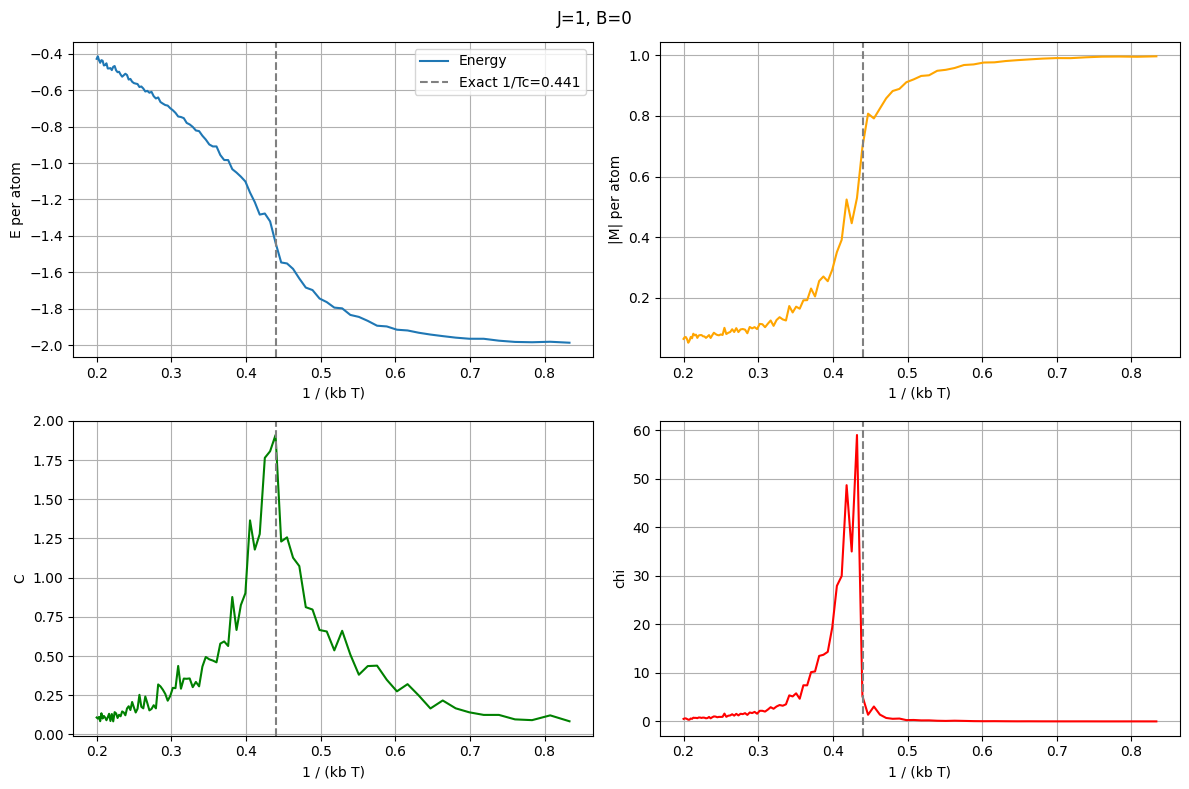

In [25]:
results_B0, aux1 = run_simulation(N=20, J=1, B=0, mode='hot')
plot_results(results_B0, J=1, B=0)

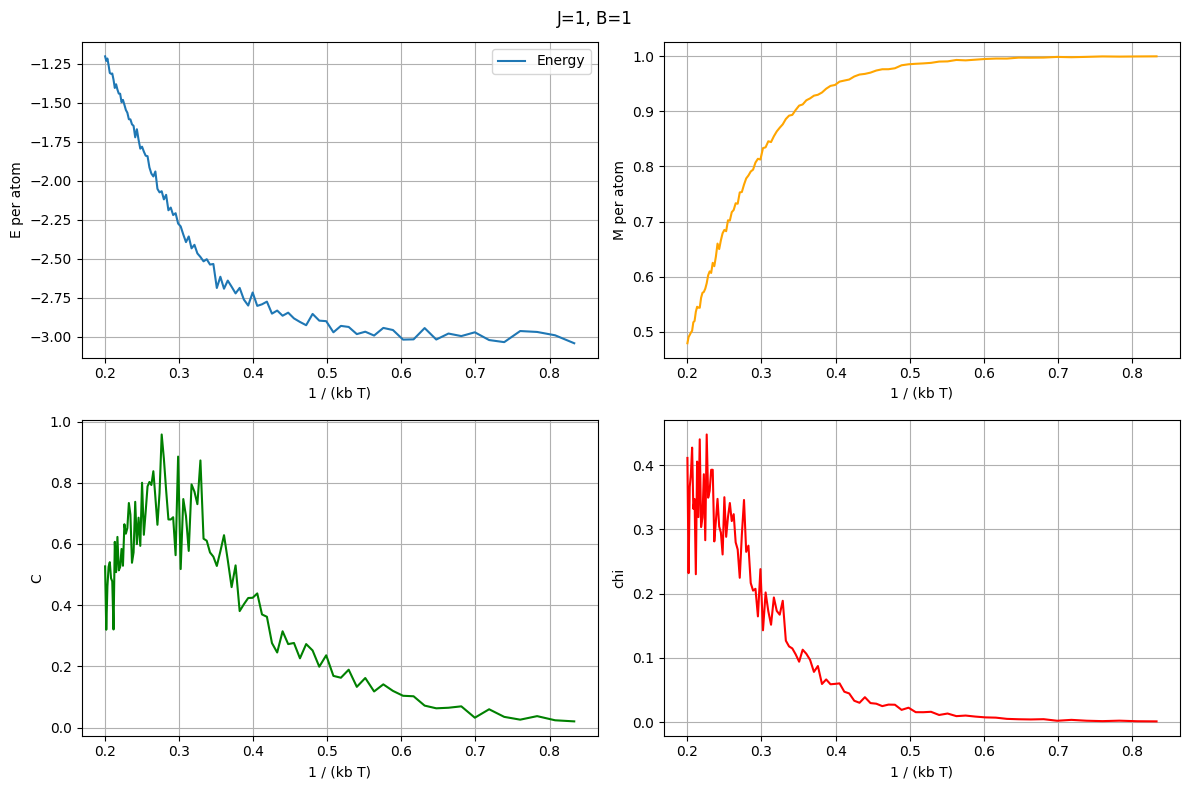

In [26]:
results_B1, _ = run_simulation(N=20, J=1, B=1, mode='hot')
plot_results(results_B1, J=1, B=1)

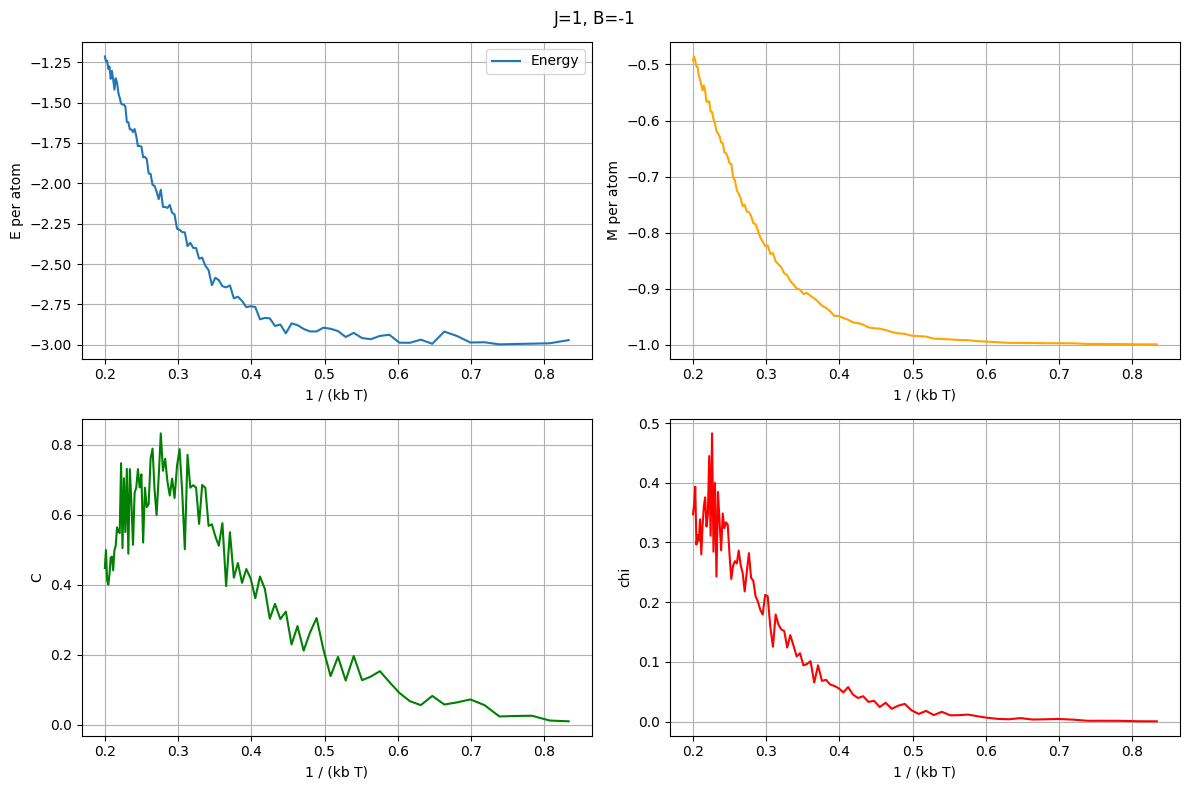

In [27]:
results_minus_B1, _ = run_simulation(N=20, J=1, B=-1, mode='hot')
plot_results(results_minus_B1, J=1, B=-1)

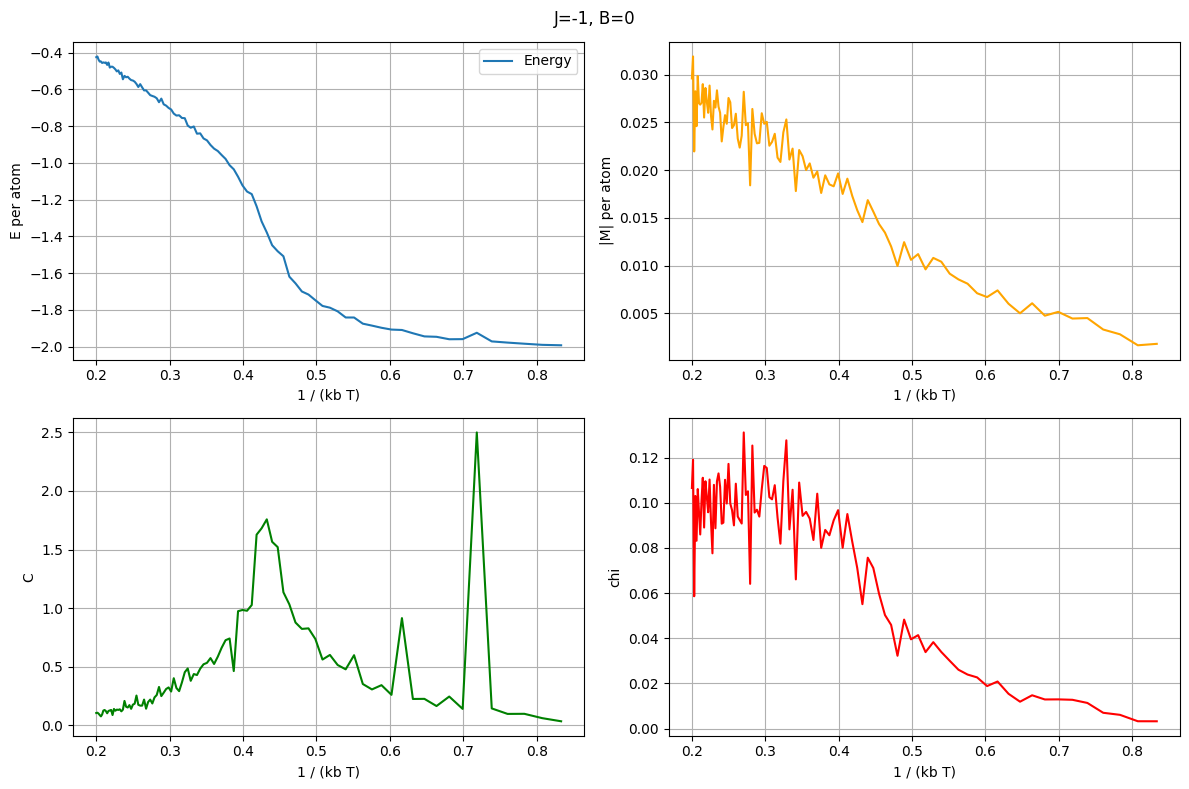

In [28]:
results_AF, _ = run_simulation(N=20, J=-1, B=0, mode='hot')
plot_results(results_AF, J=-1, B=0)

In [29]:
def critical_inv_T(results):
    inv_T = 1 / np.array(results['T'])
    C = np.array(results['C'])
    idx_C_peak = np.argmax(C)
    inv_Tc_C = inv_T[idx_C_peak]

    return inv_Tc_C

In [30]:
Tc_B0 = critical_inv_T(results_B0)
print(f"1/kb*T_c για B=0: {Tc_B0:.6f}")

1/kb*T_c για B=0: 0.439609


In [31]:
exact_inv_Tc = 0.4406868
error_abs = np.abs(Tc_B0 - exact_inv_Tc)
error_rel = (error_abs / exact_inv_Tc) * 100

print(f"Absolute error: {error_abs:.6f}")
print(f"Relative error: {error_rel:.3f}%")

Absolute error: 0.001078
Relative error: 0.245%


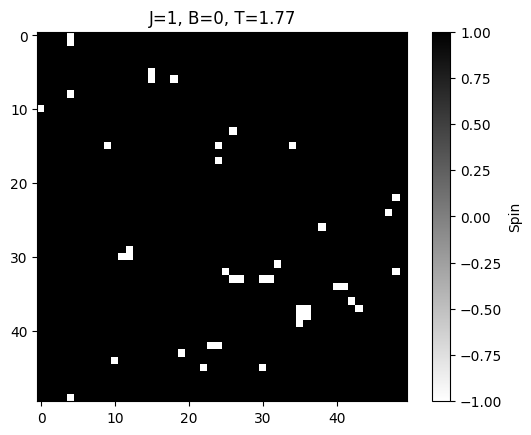

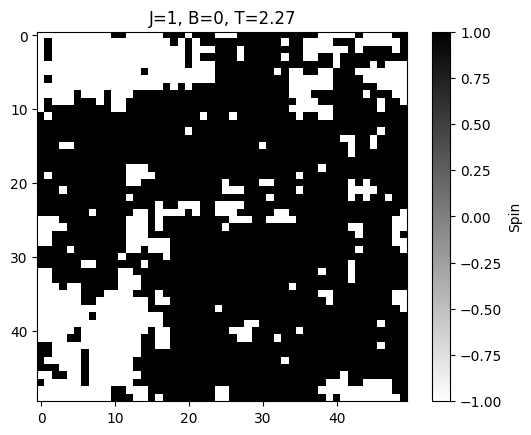

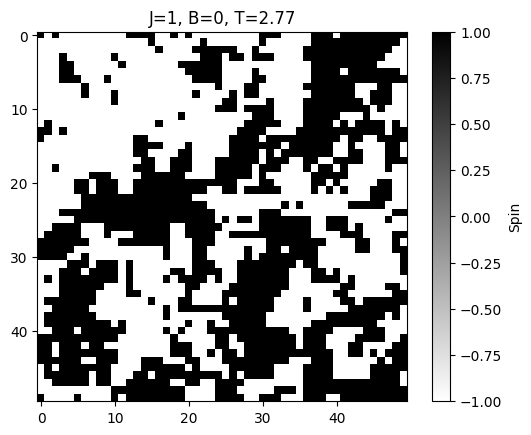

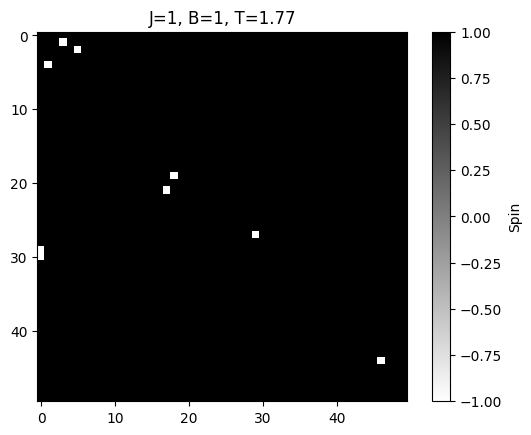

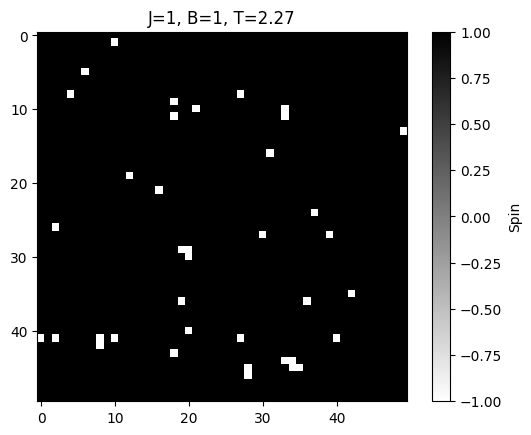

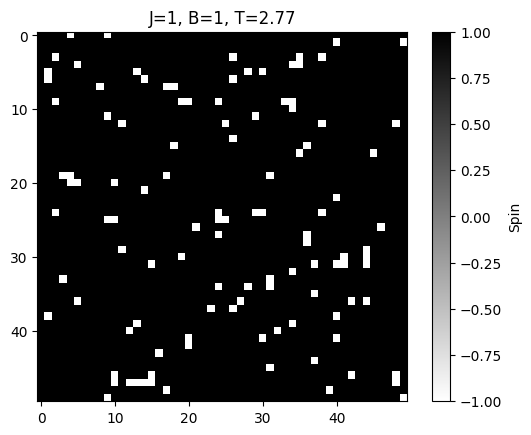

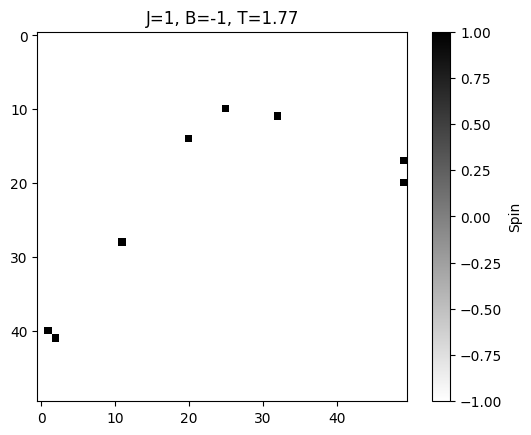

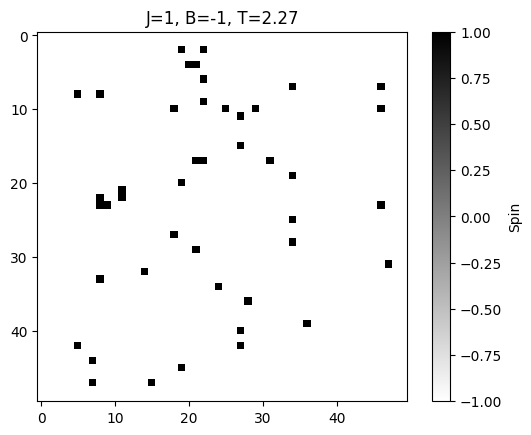

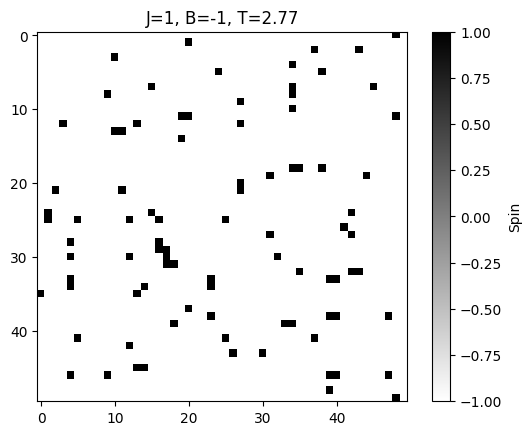

In [33]:
plot_spin(Tc_B0, B=0, N=50, J=1)
plot_spin(Tc_B0, B=1, N=50, J=1)
plot_spin(Tc_B0, B=-1, N=50, J=1)

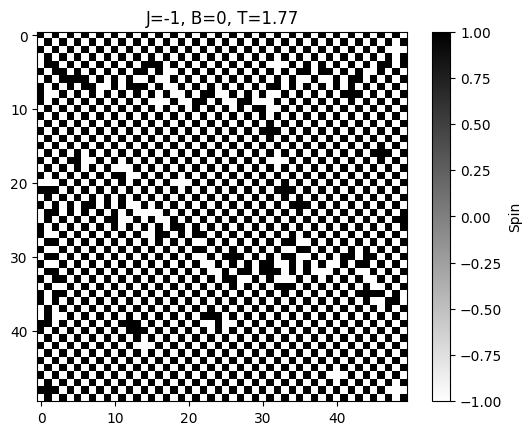

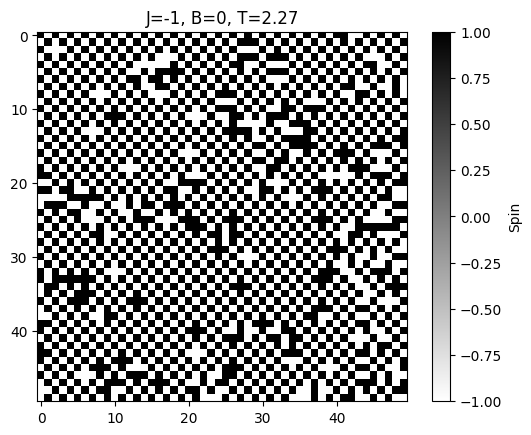

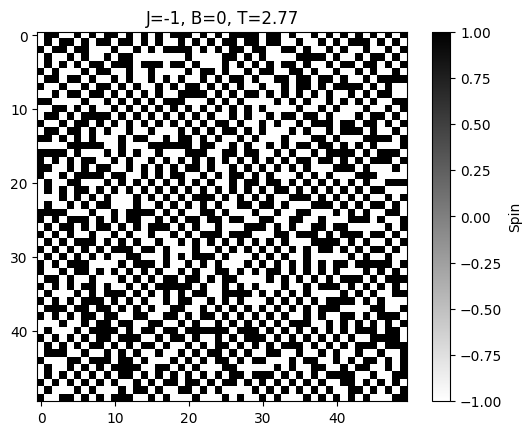

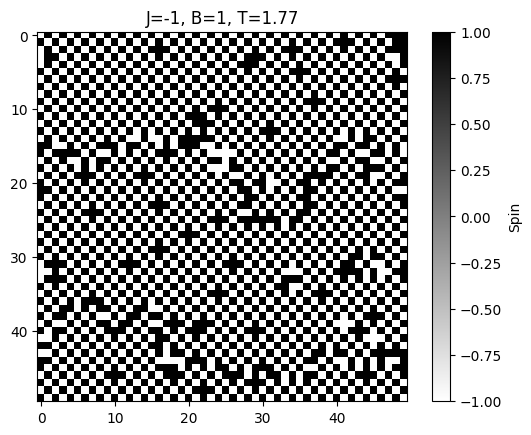

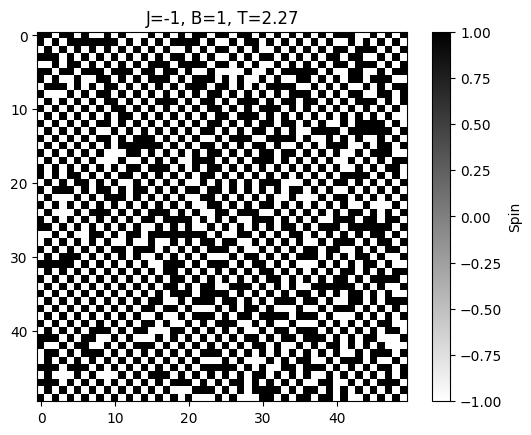

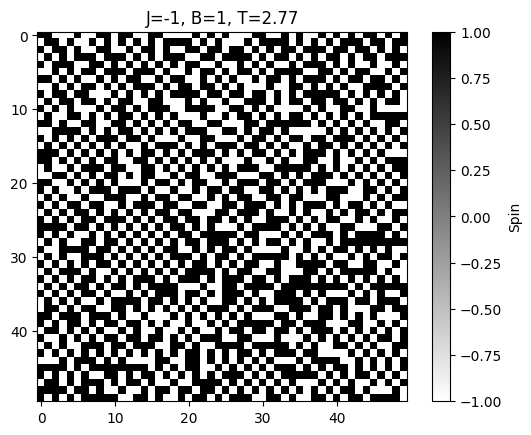

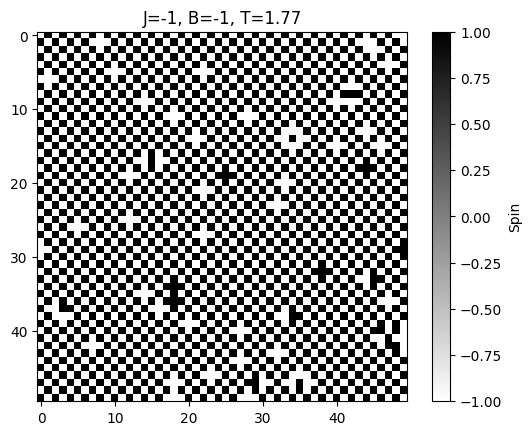

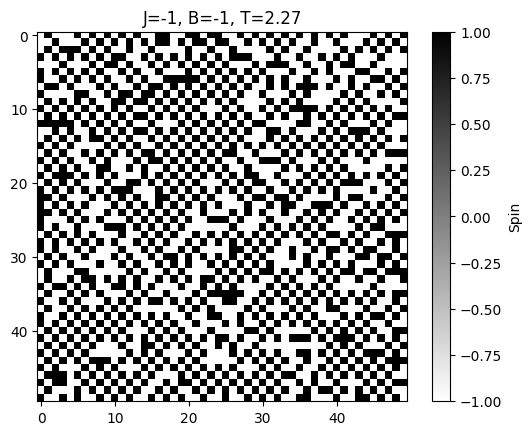

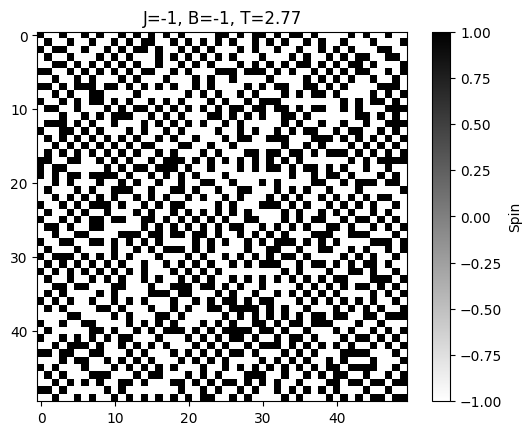

In [34]:
plot_spin(Tc_B0, B=0, N=50, J=-1)
plot_spin(Tc_B0, B=1, N=50, J=-1)
plot_spin(Tc_B0, B=-1, N=50, J=-1)

In [57]:
#EOF